# Result analysis
Let's see if someone actually learned AI-speak!

In [1]:
import os
import json
from types import SimpleNamespace
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 8)

In [3]:
files = [file for file in os.listdir('./') if file.endswith('.json')]
results = [json.load(open(file), object_hook=lambda d: SimpleNamespace(**d)) for file in files]

In [4]:
correctness = np.array([[question.correct for question in result] for result in results])
correctness.shape

(3, 64)

In [5]:
correct_count = np.cumsum(correctness, 1)
correct_count.shape

(3, 64)

In [6]:
baseline = 0.25

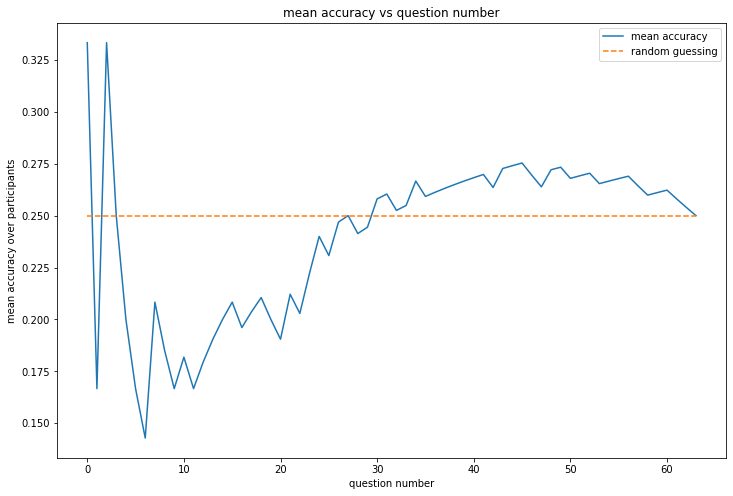

In [7]:
accuracy = correct_count / np.arange(1, correctness.shape[1] + 1)
plt.title('mean accuracy vs question number')
plt.xlabel('question number')
plt.ylabel('mean accuracy over participants')
plt.plot(accuracy.mean(0), label='mean accuracy')
plt.plot([baseline] * accuracy.shape[1], '--', label='random guessing')
plt.legend()
plt.show()

In [8]:
def p_value(num_trials, succes_probability, num_successes):
    binomial = scipy.stats.binom(num_trials, succes_probability)
    return 1 - binomial.cdf(num_successes - 1)

print(f'grand total p-value: {p_value(np.prod(correctness.shape), 0.25, np.sum(correctness))}')
print(f'p-value in last 32 questions: {p_value(np.prod(correctness[:, -32:].shape), 0.25, np.sum(correctness[:, -32:]))}')

grand total p-value: 0.5276820748833717
p-value in last 32 questions: 0.6315120018585589


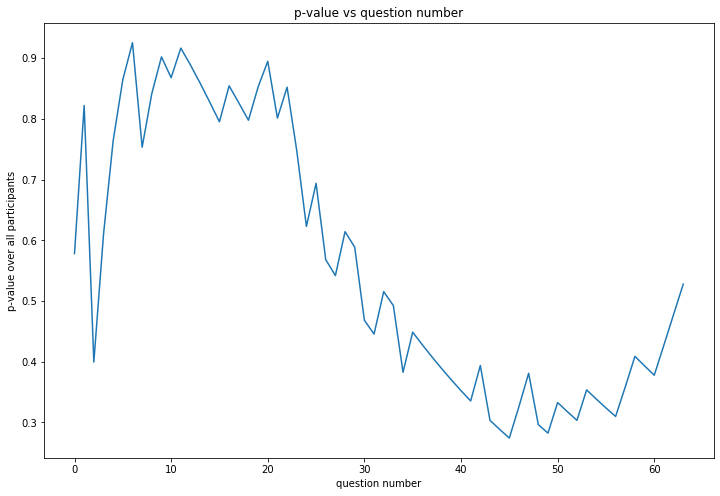

In [9]:
plt.title('p-value vs question number')
plt.xlabel('question number')
plt.ylabel('p-value over all participants')
plt.plot([p_value(len(correctness) * (idx + 1), 0.25, count) for idx, count in enumerate(correct_count.sum(0))])
plt.show()